# Text classification using CNN

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)
Сравнить две архитектуры с предобученными весами и когда Embedding обучается сразу со всей сеточкой, что получилось лучше



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from collections import Counter
from pymorphy2 import MorphAnalyzer
from razdel import tokenize
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# from stop_words import get_stop_words
from string import punctuation
import nltk
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
RANDOM_STATE = 42

Загрузка данных


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/NLP/7 урок/отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


есть пропущенные значения, посмотрим их

In [ ]:
df.loc[df.Content.isna()]

,Rating,Content,Date
2587,5,NaN,2017-08-10
3533,5,NaN,2017-08-09
9161,4,NaN,2017-08-01


Удалю, раз отсутсвуют важные данные

In [ ]:
df.dropna(inplace=True)
df.shape

(20656, 3)

In [ ]:
# Оценки пользователей от 1 до 5
df.Rating.value_counts()

5    14584
1     2276
4     2137
3      911
2      748
Name: Rating, dtype: int64

In [ ]:
# Перевожу все тексты в текстовый формат, чтобы не было ошибки при токенизации
df['Content'] = df['Content'].astype(str)



Разбиваю отзывы на метки (посмотрим куда отнести отзывы с оценкой "3")

In [ ]:
for text in df.loc[df['Rating'] == 3].head(5)['Content']:
    print(text)

При заходе дважды требует пароль.и на оплате электроэнергии виснет намертво на первом листе списка и висит загрузка вечно (
При рабочем интернете приложение никак не может соединиться с сервером. Исправьте
Медленно
Почему список уведомлений доступен без регистрации и его невозможно очистить? Когда добавите платежи через приложение с помощью NFC? В приложении не видна переписка с банком.
Сделайте возможность помечать все уведомления как прочитанные. Сейчас в списке уведомлений непонятно, какое из них прочитано, а какое нет (т.е. не прочитанные не выделены жирным шрифтом или еще как-то). Значок о непрочитанных уведомлениях висит над иконкой приложения и раздражает.


Больше негативных отзывов, так что добавим в класс "1", к отзывам с рейтином 1 и 2. 4 и 5 будут позитивные "0"

In [ ]:
df['label'] = df.Rating.apply(lambda x: 0 if x in (4, 5) else 1 )
df.sample(5)

,Rating,Content,Date,label
11284,4,Все нравится,2017-07-29,0
3895,5,Все очень нравится!!!!!,2017-08-08,0
20033,5,Норм приложение.,2017-06-16,0
13135,1,Уберите этот тупой антивирус! 1. Из-за него те...,2017-07-26,1
12757,5,Удобно,2017-07-26,0


In [ ]:
# Распределение классов
df['label'].value_counts()

0    16721
1     3935
Name: label, dtype: int64

Достаточно большой дисбаланс классов, так что метрика
accuracy не подойдет для оценки. В процессе обучения
сетей будем мониторить метрику ROC-AUC, т.к. F1-score будет
нестабильна из-за вляния значения порога классификации.
При оценке результатов обучения будем выводить classification
report и ориентироваться на значения F1-score по классам.

Сперва обучу свою модель, сделав предобработку
(стоп слова не буду использовать, много отзывов оставалось пустыми)

In [ ]:
# sw = set(get_stop_words('ru'))
lemmatize = MorphAnalyzer()

In [ ]:
# разделим данные на тренировочные и валидационные
X_train, X_val, y_train, y_val = train_test_split(df['Content'], df['label'].values,
                                                  test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
X_train

14796      Все устраивает. Удобно. Быстро. Банк в кармане.
6735                                                Олекум
149      Хорошее приложение, но «антивирус» очень загру...
3070     В целом нравится. В последнее время иногда выл...
8163                                  Отличное приложение!
                               ...                        
11287                                          Всё отлично
11967                                       Супер!!!!!!!!!
5392                                           Все успешно
860                                  Сбербанк всегда рядом
15798                             Тормозит после установки
Name: Content, Length: 15492, dtype: object

In [ ]:
def preprocess_txt(text):

  # Чистим пунктуацию
  text = re.sub(fr'[{punctuation}]+', ' ', text)

  # Убираем всё, не являющееся набором букв, + цифры
  text = ' '.join(word for word in text.split() if word.isalpha())
  # Приводим к общему регистру
  text = text.lower()

  # # Токенизация с помощью библиотеки razdel
  text = tokenize(text)
  # Лемматизация
  text = ' '.join(lemmatize.parse(token.text)[0].normal_form for token in text)

  # Убираем стопслова
  # text = [word for word in text if word not in sw]

  # Возвращаем обработанный текст
  return text


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tqdm.pandas()
X_train_my = X_train.progress_apply(preprocess_txt)
X_val_my = X_val.progress_apply(preprocess_txt)

  0%|          | 0/15492 [00:00<?, ?it/s]

  0%|          | 0/5164 [00:00<?, ?it/s]

In [ ]:
X_val_my.shape

(5164,)

In [ ]:
X_train_my

14796           всё устраивать удобно быстро банк в карман
6735                                               олекума
149          хороший приложение но очень загружать система
3070     в целое нравиться в последний время иногда выл...
8163                                   отличный приложение
                               ...                        
11287                                          всё отлично
11967                                                супер
5392                                           всё успешно
860                                  сбербанк всегда рядом
15798                            тормозить после установка
Name: Content, Length: 15492, dtype: object

Для выбора длины последовательностей оценим распределение
длин по датасету

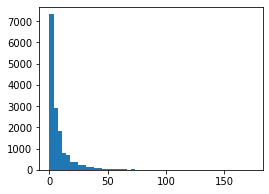

In [ ]:
plt.figure(figsize=(4, 3))
plt.hist(X_train_my.apply(lambda x: len(x.split())), bins=50);

25 будет оптимально

In [ ]:
MAX_LEN = 25

In [ ]:
# корпус текста
train_corpus = " ".join(X_train_my).lower()
train_corpus

'всё устраивать удобно быстро банк в карман олекума хороший приложение но очень загружать система в целое нравиться в последний время иногда вылетать я не нравиться только уведомление в сам приложение зачем они нужный я не понять если смс приходить итак о весь действие отличный приложение всё круто исправлять оценка на не быть возможность войти из за якобы включить root доступ с телефон никакой манипуляция не производиться снести приложение через неделя установить всё работать за отсутствие возможность досрочный погашение кредит удобно всё есть всегда под рука не надо стоять в банк я нравиться всё что иня нужно есть при вход в приложение постоянно проверять прошивка и производить инициализация антивирус пароль запрашивать два раз подряд вводить первый раз ждать пока всё загрузиться затем он просить ввести пароль второй раз и снова загружать приложение на всё это уходить много время а в остальной всё устраивать всё что я нужно в приложение есть нарекание нет всё работать я устраивать оч

In [ ]:
# скок ттокенов
dist = Counter(train_corpus.split())

In [ ]:
vocabulary = {w: i for i, w in dict(enumerate(dist.keys(), 1)).items()}
# vocabulary

In [ ]:
len(vocabulary)

7216

In [ ]:
VOCAB_SIZE = len(vocabulary) + 1

In [ ]:
# преобразование текста в последовательность
def text_to_sequence(text):
    result = []
    tokens = tokenize(text)
    for token in text.split():
        if token in vocabulary:
            result.append(vocabulary[token]) # если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (MAX_LEN-len(result)) # нули дополняющие до maxlen
    return result[-MAX_LEN:] + padding

In [ ]:
X_train_padded = X_train_my.apply(text_to_sequence)
X_val_padded = X_val_my.apply(text_to_sequence)

In [ ]:
X_train_padded.sample(5)

753      [91, 1, 611, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4907     [215, 611, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
19221    [41, 22, 2237, 52, 927, 21, 1100, 238, 239, 0,...
17308    [10, 22, 373, 146, 147, 83, 600, 99, 23, 236, ...
7364     [122, 552, 121, 79, 156, 366, 572, 46, 9, 10, ...
Name: Content, dtype: object

In [ ]:
print(f"Оригинальная строка: {X_train_my.iloc[5]}")
print(f"Обработанная строка: {X_train_padded[5]}")

Оригинальная строка: всё круто
Обработанная строка: [1, 3, 272, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Подготовлю датасет для подготовки даталоадеров, для предобученных
эмбеддингов и своей модели.

In [ ]:
class DataWrapper(Dataset):
    def __init__(self, texts, labels, pretrained=False):
        
        self.pretrained = pretrained
        if self.pretrained:
            self.texts = [tokenizer(text, padding='max_length', max_length=MAX_LEN,
                                truncation=True, return_tensors='pt')
                          for text in texts]
        else:
            self.texts = texts.values
        self.labels = labels
    
    def __getitem__(self, index):
        x = self.texts[index] if self.pretrained else torch.IntTensor(self.texts[index])
        return x, self.labels[index]
    
    def __len__(self):
        return len(self.texts)

In [ ]:
# Training
BATCH_SIZE = 512

In [ ]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = DataWrapper(X_train_padded, y_train, pretrained=False)
val_dataset = DataWrapper(X_val_padded, y_val, pretrained=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Подготовлю класс нейросети, который поддерживает
с предобученными эмбеддингами и обработанных данных

In [ ]:
class ConvModel(nn.Module):
    def __init__(self, conv_out=128, pretrained=False, embedding_dim=256, vocab_size=None):
        if not pretrained:
            assert vocab_size is not None, 'Vocabulary size should be given when using non-pretrained model'
        super().__init__()
        self.pretrained = pretrained
        self.embedding_dim = 768 if self.pretrained else embedding_dim
        self.embedding = model.bert.embeddings if self.pretrained else \
                         nn.Embedding(vocab_size, self.embedding_dim, padding_idx=0)
        self.conv = nn.Sequential(nn.Conv1d(self.embedding_dim, out_channels=conv_out, kernel_size=3),
                                  nn.MaxPool1d(MAX_LEN - 2),
                                  nn.ReLU())
        self.fc1 = nn.Sequential(nn.Linear(conv_out, conv_out // 4),
                                 nn.ReLU())
        self.dp = nn.Dropout(0.5)
        self.fc2 = nn.Linear(conv_out // 4, 1)
        
    def forward(self, x):
        x = torch.squeeze(x['input_ids']) if self.pretrained else x
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc1(torch.squeeze(x))
        x = self.dp(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
    
    def predict(self, x):
        if self.pretrained:
            x = tokenizer(x, padding='max_length', max_length=MAX_LEN,
                          truncation=True, return_tensors='pt').to(device)
            x = self.forward(x)
        
        else:
            x = torch.Tensor([self.forward(torch.IntTensor(line)[np.newaxis, :].to(device)) for line in x])
        
        return torch.squeeze((x >= 0.5) * 1)

Посмотрим на параметры

In [ ]:
net = ConvModel(vocab_size=VOCAB_SIZE)

In [ ]:
summary(net)

Layer (type:depth-idx)                   Param #
ConvModel                                --
├─Embedding: 1-1                         1,847,552
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       98,432
│    └─MaxPool1d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-4                       4,128
│    └─ReLU: 2-5                         --
├─Dropout: 1-4                           --
├─Linear: 1-5                            33
Total params: 1,950,145
Trainable params: 1,950,145
Non-trainable params: 0

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Обучим модель

In [ ]:
def train_nn(epochs=5, conv_out=128, pretrained=False, vocab_size=None, return_model=False):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    
    net = ConvModel(conv_out=conv_out, pretrained=pretrained, vocab_size=vocab_size).to(device)
    if pretrained:
        for param in net.embedding.parameters():
            param.requires_grad = False

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        train_losses = np.array([])
        test_losses = np.array([])
        train_metrics = np.array([])
        test_metrics = np.array([])

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            train_losses = np.append(train_losses, loss.item())

            net.eval()
            outputs = net(inputs)
            try:
                train_metrics = np.append(train_metrics, roc_auc_score(labels.cpu().detach().numpy(), 
                                                                       outputs.cpu().detach().numpy(), average='weighted'))
            except ValueError:
                pass

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {train_losses.mean():.3f}. ' \
              f'ROC-AUC: {train_metrics.mean():.3f}', end='. ')


        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels.float().view(-1, 1))
                test_losses = np.append(test_losses, loss.item())
                try:
                    test_metrics = np.append(test_metrics, roc_auc_score(labels.cpu().detach().numpy(), 
                                                                         outputs.cpu().detach().numpy(), average='weighted'))
                except ValueError:
                    pass

        print(f'Test loss: {test_losses.mean():.3f}. ROC-AUC: {test_metrics.mean():.3f}')

    print('Training is finished!')
    if return_model:
        return net

In [ ]:
net = train_nn(epochs=20, vocab_size=VOCAB_SIZE, return_model=True)

Epoch [1/20]. Loss: 0.615. ROC-AUC: 0.553. Test loss: 0.564. ROC-AUC: 0.547
Epoch [2/20]. Loss: 0.528. ROC-AUC: 0.633. Test loss: 0.488. ROC-AUC: 0.718
Epoch [3/20]. Loss: 0.460. ROC-AUC: 0.806. Test loss: 0.422. ROC-AUC: 0.846
Epoch [4/20]. Loss: 0.403. ROC-AUC: 0.874. Test loss: 0.374. ROC-AUC: 0.886
Epoch [5/20]. Loss: 0.361. ROC-AUC: 0.902. Test loss: 0.340. ROC-AUC: 0.905
Epoch [6/20]. Loss: 0.335. ROC-AUC: 0.915. Test loss: 0.315. ROC-AUC: 0.915
Epoch [7/20]. Loss: 0.307. ROC-AUC: 0.929. Test loss: 0.296. ROC-AUC: 0.924
Epoch [8/20]. Loss: 0.290. ROC-AUC: 0.937. Test loss: 0.281. ROC-AUC: 0.929
Epoch [9/20]. Loss: 0.277. ROC-AUC: 0.942. Test loss: 0.269. ROC-AUC: 0.935
Epoch [10/20]. Loss: 0.260. ROC-AUC: 0.948. Test loss: 0.261. ROC-AUC: 0.938
Epoch [11/20]. Loss: 0.249. ROC-AUC: 0.953. Test loss: 0.254. ROC-AUC: 0.940
Epoch [12/20]. Loss: 0.235. ROC-AUC: 0.957. Test loss: 0.248. ROC-AUC: 0.942
Epoch [13/20]. Loss: 0.229. ROC-AUC: 0.959. Test loss: 0.243. ROC-AUC: 0.943
Epoch [1

In [ ]:
# предсказание
pred = net.predict(X_val_padded)

In [ ]:
# функция для извлечения значений метрик из classification report
def get_class_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_0 = round(report['0']['f1-score'], 3)
    f1_1 = round(report['1']['f1-score'], 3)
    f1_macro = round(report['macro avg']['f1-score'], 3)
    return f1_0, f1_1, f1_macro

In [ ]:
names = ['No_pretrained embeddings']
nopretrained = get_class_report(y_val, pred.cpu())

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4182
           1       0.75      0.74      0.74       982

    accuracy                           0.90      5164
   macro avg       0.84      0.84      0.84      5164
weighted avg       0.90      0.90      0.90      5164



Теперь займемся моделью с предобученными эмбедингами, возьму модель BERT. Загрузим её:

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-multilingual-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Оценим распределение

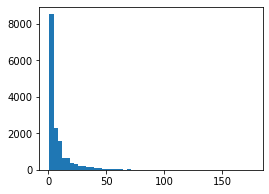

In [ ]:
plt.figure(figsize=(4, 3))
plt.hist(X_train.apply(lambda x: len(x.split())), bins=50);

In [ ]:
MAX_LEN = 30

In [ ]:
torch.random.manual_seed(RANDOM_STATE)

train_dataset = DataWrapper(X_train, y_train, pretrained=True)
val_dataset = DataWrapper(X_val, y_val, pretrained=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Будем исползовать следующий слой модели BERT:

In [ ]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(105879, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Посмотрим на число параметров сети, "заморозим" веса
предобученных эмбеддингов:

In [ ]:
net = ConvModel(pretrained=True)
for param in net.embedding.parameters():
    param.requires_grad = False

In [ ]:
summary(net)

Layer (type:depth-idx)                   Param #
ConvModel                                --
├─BertEmbeddings: 1-1                    --
│    └─Embedding: 2-1                    (81,315,072)
│    └─Embedding: 2-2                    (393,216)
│    └─Embedding: 2-3                    (1,536)
│    └─LayerNorm: 2-4                    (1,536)
│    └─Dropout: 2-5                      --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-6                       295,040
│    └─MaxPool1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-9                       4,128
│    └─ReLU: 2-10                        --
├─Dropout: 1-4                           --
├─Linear: 1-5                            33
Total params: 82,010,561
Trainable params: 299,201
Non-trainable params: 81,711,360

Обучим модель

In [ ]:
net = train_nn(epochs=20, pretrained=True, return_model=True)

Epoch [1/20]. Loss: 0.489. ROC-AUC: 0.888. Test loss: 0.382. ROC-AUC: 0.907
Epoch [2/20]. Loss: 0.364. ROC-AUC: 0.913. Test loss: 0.325. ROC-AUC: 0.917
Epoch [3/20]. Loss: 0.321. ROC-AUC: 0.923. Test loss: 0.289. ROC-AUC: 0.929
Epoch [4/20]. Loss: 0.291. ROC-AUC: 0.933. Test loss: 0.263. ROC-AUC: 0.939
Epoch [5/20]. Loss: 0.269. ROC-AUC: 0.940. Test loss: 0.247. ROC-AUC: 0.944
Epoch [6/20]. Loss: 0.257. ROC-AUC: 0.944. Test loss: 0.238. ROC-AUC: 0.948
Epoch [7/20]. Loss: 0.242. ROC-AUC: 0.948. Test loss: 0.230. ROC-AUC: 0.950
Epoch [8/20]. Loss: 0.237. ROC-AUC: 0.952. Test loss: 0.227. ROC-AUC: 0.951
Epoch [9/20]. Loss: 0.229. ROC-AUC: 0.954. Test loss: 0.222. ROC-AUC: 0.953
Epoch [10/20]. Loss: 0.223. ROC-AUC: 0.956. Test loss: 0.219. ROC-AUC: 0.954
Epoch [11/20]. Loss: 0.217. ROC-AUC: 0.958. Test loss: 0.217. ROC-AUC: 0.955
Epoch [12/20]. Loss: 0.211. ROC-AUC: 0.961. Test loss: 0.214. ROC-AUC: 0.956
Epoch [13/20]. Loss: 0.206. ROC-AUC: 0.963. Test loss: 0.213. ROC-AUC: 0.956
Epoch [1

In [ ]:
pred = net.predict(X_val.tolist())

In [ ]:
names.append('Pretrained embeddings')
pretrained_scores = get_class_report(y_val, pred.cpu())

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4182
           1       0.77      0.77      0.77       982

    accuracy                           0.91      5164
   macro avg       0.86      0.86      0.86      5164
weighted avg       0.91      0.91      0.91      5164



Соберу все в одну таблицу для сравнения

In [ ]:
pd.DataFrame([nopretrained, pretrained_scores],
             index=names,
             columns=['F1-score 0', 'F1-score 1', 'F1-score macro']).sort_values('F1-score macro', ascending=False)

,F1-score 0,F1-score 1,F1-score macro
Pretrained embeddings,0.946,0.769,0.857
No_pretrained embeddings,0.940,0.741,0.841


Лучше результат показала модель свёрточной сети с предобученными
эмбеддингами. Для улучшения своей модели можно попробовать сделать более детальную предобработку текста, а в общем и целом результат не плохой.
